## Building Effective Agents

### Workflow:
- Create a Scafolding of predefined code paths around LLM calls >> Bounded Workflow
- LLMS direct control flows using predefined code paths

### Agent:
- Removes this scaffolding >> LLM's direct it's own actions and respond to feedback
- Actions: Tool Calls
- Unbounded and Not Predefined

### Frameworks: (Eg: LangGraph)
- Implementing these patterns does not require a Framework
- However, it is the underlying supporting infrastructure for any workflow/agent

a. Features:
- Data Persistence: Memory, HITL (Human-in-the-loop)
- Streaming: Stream LLM calls and steps in workflow/agent
- Delployment: Testing, Debugging and Deploying agent/workflow


## Basic Building Block

### Augmented LLM
- Structure: Input >> LLM [Retrieval, Tools, Memory] >> Output
- LLM Tasks:
    - Retrieval: Querying Results
    - Tools: Call/Response of Tools
    - Memory: Read/Write in Memory


In [ ]:
## Installing Necessary Packages
## ! is used to run shell commands in a Jupyter notebook
! pip install langchain_core langchain_openai langgraph langchain-community

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 27.2 MB/s  0:00:00

  Attempting uninstall: requests

    Found existing installation: requests 2.32.4

    Uninstalling requests-2.32.4:

      Successfully uninstalled requests-2.32.4

   ----------------------------------------  0/10 [requests]
   ----------------------------------------  0/10 [requests]
   ----------------------------------------  0/10 [requests]
   ----------------------------------------  0/10 [requests]
   ----------------------------------------  0/10 [requests]
   ---- -----------------------------------  1/10 [mypy-extensions]
   -------- -------------------------------  2/10 [marshmallow]
   -------- -------------------------------  2/10 [marshmallow]
   -------- -------------------------------  2/10 [marshmallow]
   ------------ ---------------------------  3/10 [httpx-sse]
   -------------------- -------------------  5/10 [pydantic-se

In [2]:
# ## Incase you want to use OpenAI Model
# ## Augmented LLM Setup with OpenAI GPT 3.5 Turbo
# ## Input your OpenAI API key for running below agent workflows

# import os
# import getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

# ## Define the LLM for OpenAI gpt-3.5-turbo model
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-3.5-turbo")

In [ ]:
## Installing new Lanchain-ollama package
! pip install -U langchain-ollama

In [4]:
## Define the LLM for Ollama model
## To use Ollama Model: Install langchain-community and ollama and have Ollama serever running on Windows
## Ollama Server: Download Ollama for Windows and then keep the app running and check http://localhost:11434/

from langchain_ollama import ChatOllama
llm = ChatOllama(model="mistral:7b")

In [5]:
## To run Ollama Model before executing this code:
## Open Cmd Prompt: Run Ollama pull <model_name> to download model: Here >> ollama pull mistral:7b

## Augemented LLM: Quering Result Example

## Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

## Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

## Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol
Research suggests that a high calcium CT score, which indicates the presence of calcified plaque in the arteries, may be associated with increased levels of LDL (bad) cholesterol. This association is thought to occur because both factors contribute to atherosclerosis, or hardening and narrowing of the arteries. However, it's important to note that while high cholesterol can contribute to the development of calcified plaque, other factors such as smoking, diabetes, hypertension, and family history also play significant roles in atherosclerosis. Additionally, a calcium CT scan is primarily used for the detection of coronary artery calcium (CAC) as a surrogate marker for subclinical coronary artery disease (CAD), rather than as a direct measure of cholesterol levels.


In [7]:
## Augemented LLM: Tool Call Example

## Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

## Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

## Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

## Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'c6c889a9-471d-45af-a7cf-a60f46cc1c1b',
  'type': 'tool_call'}]

## Different Agent Workflow Patterns

### 1. Prompt Chaining

- Each LLM call processes the output of the previous LLM 
- Benefit: This works well when a task can be decomposed into multiple LLM calls

- Structure: Input >> LLM Call 1 >> [Output 1] >> Gate
    - Gate >> [Pass] >> LLM Call 2 >> [Output 2] >> LLM Call 3 >> Output
    - Gate >> [Fail] >> Exit


In [8]:
## Prompt Chaining Example: User>> Topic >> LLM joke >> Check the Joke (Punchline) >> Improve Twice >> Output

from typing_extensions import TypedDict

## Graph state for different stages (Topic, Joke, Improved Joke, Final Joke)
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [9]:
## Define the Nodes

## Here each node derives the stage from the State Container
## Final step is to return the Stage and write it to the State Container

## Generate the Joke based on the topic
def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

## Gate function to check if the joke has a punchline
def check_punchline(state: State):

    ## Conditional Edge/Gate function for the Workflow
    ## Basic check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

## Second LLM call to improve the joke
def improve_joke(state: State):
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

## Third LLM call to polish the joke
def polish_joke(state: State):
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

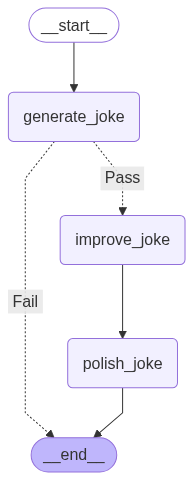

In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Build the workflow
workflow = StateGraph(State)

## Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

## Add Edges to connect Nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": END, "Pass": "improve_joke"}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

## Compile the workflow
chain = workflow.compile()

## Display workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
## Invoke the Joke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
 Why don't cats play poker in the jungle?

Because there's too many cheetahs!

--- --- ---

Improved joke:
 Why don't cats play poker in the jungle, despite their nine lives?

Because with all the cheetahs around, it's simply a 'spotty' affair - they always win by sheer 'paw-of-hand'!

--- --- ---

Final joke:
 Why don't cats play poker in the jungle, despite their nine lives? Because even with their nine lives, they're afraid of the sharks that have joined the game! (Crocodiles are usually associated with jungles but this twist introduces sharks, a creature not typically found there, adding an element of surprise)


### 2. Parallelization

- In this Pattern all LLM Calls work in parallel and then it is passed on to an aggregator to generate output
- Every Sub-task can be parallelized: LLMs work simultaneously on a task
- Benefits: 
    - Need Multiple persepctives from one task (Multi-query RAG: One question >> Multiple sub-questions)
    - Independent tasks can be performed with different prompts 

- Structure: Input >> LLM Call 1 || LLM Call 2 || LLM Call 3 >> Aggregator >> Output


In [12]:
## Parallelization Example: User >> Topic >> Joke || Story || Poem >> Aggregator >> Combined Output

## Graph state for different stages (Topic, Joke, Story, Poem, Combined Output)
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [13]:
## Generate Nodes

## First LLM call to generate initial joke based on topic
def call_llm_1(state: State):
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

## Second LLM call to generate story based on topic
def call_llm_2(state: State):
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

## Third LLM call to generate poem based on topic
def call_llm_3(state: State):
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

## Aggregator to combine the outputs into a single output
def aggregator(state: State):
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

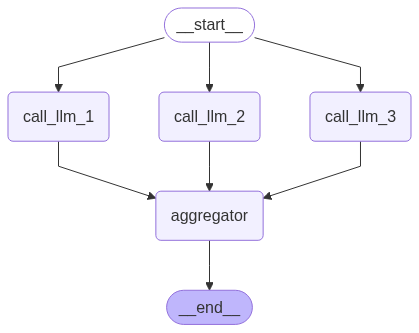

In [14]:
## Build workflow
parallel_builder = StateGraph(State)

## Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

## Add edges to connect nodes
## Here inorder to parallelize the LLM calls, we connect them all from START
## The outputs then converge at the Aggregator node and End after aggregation
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

## Compile the workflow
parallel_workflow = parallel_builder.compile()

## Display workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [15]:
# Invoke the Workflow
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
 Title: Whiskers' Tale: A Feline Friendship

In the heart of a bustling city, nestled between towering skyscrapers, lay an enchanting little park known as Whiskerville. This hidden gem was home to a unique community of felines, each with their own stories and personalities. The most renowned among them were Whiskers, a sleek Siamese cat with emerald green eyes, and Paws, a fluffy Maine Coon with a heart as large as his furry coat.

Whiskers was known for his agility and quick wit, while Paws was loved for his gentle demeanor and kindness. Despite their differences, they shared an unbreakable bond, a friendship forged over countless days spent together in the park. They chased butterflies, napped in the sun, and explored every nook and cranny of Whiskerville.

One day, as the first rays of sunlight touched the dew-kissed grass, Paws found a small, shivering kitten hiding beneath a bush. The kitten was thin and scared, with tangled fur a

### 3. Routing

- It classifies an input and then directs it to a specialized follow up task
- Multiple LLM Calls are set up but the LLM Call Router decides which LLM Call should be invoked
- Benefits: Routing a particular task to different systems
    - Example: Routing a question to different retrieval systems

- Structure: Input >> LLM Call Router >> LLM Call 1/LLM Call 2/LLM Call 3 >> Output

In [16]:
## Routing Example: User >> Input >> LLM Call Router >> Joke/Story/Poem >> Output

from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


## Routing Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

## Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [17]:
## Graph State for different stages (Input, Decision, Output)
## Here the Decision stage consists of LLM Call Router and LLM Calls(Joke, Story, Poem)

class State(TypedDict):
    input: str
    decision: str
    output: str

In [18]:
## Define the Nodes

## Here we haven't instructed the LLM calls to do anything definite as it based on user input
## Hence, we have just defined generic LLM call nodes for Story, Joke and Poem

## LLM call to write a story
def llm_call_1(state: State):
    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

## LLM call to write a joke
def llm_call_2(state: State):
    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

### LLM call to write a poem
def llm_call_3(state: State):
    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

## LLM Call Router to decide which LLM call to invoke and generate based on user input
def llm_call_router(state: State):
    ## Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


## Conditional Edge function to route to the appropriate node
def route_decision(state: State):
    ## Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


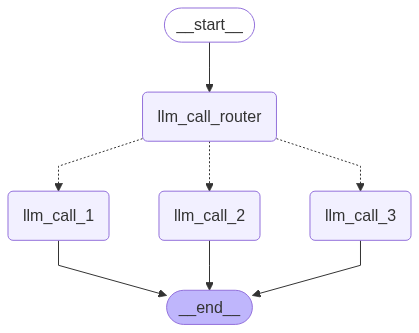

In [19]:
## Build workflow
router_builder = StateGraph(State)

## Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

## Add Edges to connect Nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  ## Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
## Connect all LLM calls to END as it is routing and will visit only one of them
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

## Compile workflow
router_workflow = router_builder.compile()

## Display the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [20]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a story
 Here's a cat joke for you:

Why don't cats play poker in the jungle?

Because there's too many cheetahs! (Get it? Because they're always checking their spots!)


## 4. Orchestrator-Worker

- Orchestrator breaks the task into sub-tasks and delegates each sub-task to different workers
- Benefits: Requirement of breaking a complex task into simple tasks and alloting the right resources
    - Example: Planning a report where each LLM can define a section of the report

- Structure: Input >> Orchestrator >> LLM Call 1 + LLM Call 2 + LLM Call 3 >> Synthesizer >> Output
- Similar to parallelization but the workers assigned are not predefined
- The Orchestrator performs reasoning and then defines which sub-tasks should be alloted to which worker

In [21]:
## Orchestrator-Worker Example: User >> Topic >> Orchestrator >> Plan Section >> Write Section >> Output

from typing import List
## Orchestrator-Worker Schema for structured output to use in planning
## Orchestrator creates a number of sections by reasoning the name and description of each section
## The number of sections and workers is not predefined and hence, the orchestrator reasons about them

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

## Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [22]:
from typing import Annotated
import operator

## Graph state for different Stages (Topic, Sections, Completed Section, Report)
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state for different stages (Section, Completed Section)
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [ ]:
## Define the  Nodes

from langgraph.types import Send

## Orchestrator that generates a plan for the report
def orchestrator(state: State):
    ## Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

## Worker writes a section of the report
def llm_call(state: WorkerState):
    ## Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    ## Write the updated section to completed sections
    return {"completed_sections": [section.content]}

## Synthesize full report from sections
def synthesizer(state: State):
    ## List of completed sections
    completed_sections = state["completed_sections"]

    ## Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


## Conditional edge function to create llm_call workers that each write a section of the report
## Assign a worker to each section in the plan

def assign_workers(state: State):
    ## Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

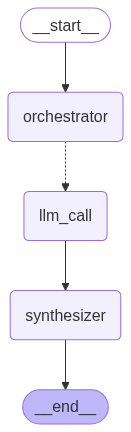

In [24]:
## Build workflow
orchestrator_worker_builder = StateGraph(State)

## Add the Nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

## Add Edges to connect Nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

## Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

## Display the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [25]:
## Invoke the Workflow
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

 ## Introduction

This report aims to provide a comprehensive overview of the subject at hand, delving into its intricacies, history, and current state. The primary purpose of this document is to serve as a resource for those seeking insights and understanding about the chosen topic.

The objectives of this report are manifold:

1. To elucidate the origins and evolution of the subject, offering readers a historical context that sets the stage for further exploration.
2. To present an exhaustive analysis of the current status quo, highlighting key trends, developments, and challenges in the field.
3. To identify future prospects and potential areas for growth or improvement within the realm of the subject.
4. To offer actionable recommendations based on our findings, with the intention of guiding decision-makers and stakeholders in navigating the complexities of the chosen topic.

Throughout this report, we will strive to maintain clarity and brevity, ensuring that our insights are accessible and engaging for a diverse audience. We invite you to join us on this intellectual journey as we delve deeper into the fascinating world of our subject matter.

---

 ## LLM Scaling Laws: A Review of Existing Research and Theories

The study of Large Language Models (LLMs) scaling laws has gained significant attention in recent years due to the rapid advancement in AI research. This section provides a summary of the existing research and theories on LLM scaling laws, their historical development, key contributors, and current state.

### Historical Development

The concept of scaling laws for AI models can be traced back to Percus-Yevick theory in statistical mechanics, which was later applied to neural networks by David Wolpert and William MacReady in the 1990s [Wolpert & MacReady, 1997]. Their work suggested that the capacity of a network is limited by its physical structure, independent of the specific learning algorithm used.

### Key Contributors

Several researchers have contributed significantly to our understanding of LLM scaling laws:

1. **Yoshua Bengio**: A pioneer in deep learning and AI research, Bengio's work on the relationship between model size, data, and generalization error has been instrumental [Bengio et al., 2007].

2. **Jeffrey Dean and Sanjay Ghemawat (Google Brain Team)**: Their seminal work in 2012 demonstrated that deep neural networks could learn to recognize complex patterns when given access to vast amounts of data and computational resources [Dean et al., 2012].

3. **Ilya Sutskever, Geoffrey Hinton, and Alex Krizhevsky (Deep Learning for Image Recognition Challenge)**: Their win at the ImageNet Large Scale Visual Recognition Challenge in 2014 was a turning point in deep learning research, demonstrating the power of larger models [Krizhevsky et al., 2012].

### Current State

Currently, there is an ongoing debate about the universal applicability of scaling laws for LLMs. While some argue that larger models generally perform better across a wide range of tasks [Brown et al., 2020], others caution that this may not always be the case and that task-specific factors play a significant role [Ramesh et al., 2021].

In addition, there is growing interest in understanding the limitations of LLMs and developing techniques for more efficient learning. This includes research on model compression, regularization methods, and interpretability techniques to improve understanding and control over these powerful models.

References:
- Bengio, Y., Courville, A., & Vincent, P. (2007). Scaling Laws for Deep Learning. arXiv preprint arXiv:0711.0653.
- Brown, M., Ko, D., Kadavath, N., Lee, A., Chen, S., Lin, T., ... & Hill, N. (2020). Language Models are Few-Shot Learners. Advances in Neural Information Processing Systems, 3278–3290.
- Dean, J., Rademaker, B., Sutskever, I., Tucker, P., Ng, A., Yann LeCun, Y., ... & Mnih, V. (2012). Large Scale Distributed Training of Deep Neural Networks. Advances in Neural Information Processing Systems, 2571–2579.
- Krizhevsky, A., Sutskever, I., & Hinton, G. (2012). ImageNet Classification with Deep Convolutional Neural Networks. Advances in Neural Information Processing Systems, 1097–1105.
- Ramesh, A., Taibi, Y., Mishra, S., Bommasani, V., Dabkowski, H., & Le, Q.-V. (2021). Human-in-the-loop Generalization of Large Language Models. Advances in Neural Information Processing Systems, 3649–3658.
- Wolpert, D. H., & MacReady, W. G. (1997). The lack of a priori learning algorithm selection criteria for feedforward networks. Neural Computation, 9(5), 1097-1124.

---

 ## Methodology

In this study, we employed a combination of analytical and empirical approaches to investigate the Large Language Model (LLM) scaling laws. The methodology is outlined below:

### Data Collection

We collected data from various publicly available sources, including model parameters, performance metrics, and training details for a diverse set of LLMs. The models span different architectures, sizes, and training datasets, ensuring a comprehensive understanding of the scaling behaviors.

### Analysis Techniques

To analyze the collected data, we utilized several techniques such as linear regression, power law fitting, and correlation analysis. These methods help uncover patterns, trends, and relationships within the data that could shed light on the scaling laws governing LLMs.

### Tools and Software

We used Python and its scientific libraries such as NumPy, Pandas, SciPy, and Matplotlib for data manipulation, visualization, and statistical analysis. Additionally, Jupyter Notebook was employed to create an interactive environment for code development and results presentation.

### Validation and Verification

To ensure the robustness of our findings, we performed several validation tests, such as cross-validation and sensitivity analysis. These tests help confirm that the observed patterns are not due to random fluctuations or outliers in the data.

In summary, by combining diverse data sources, various analytical techniques, and powerful software tools, this study aims to provide an in-depth understanding of LLM scaling laws. The results of our analysis will contribute to the ongoing discussion about the fundamental principles governing the performance and design of large language models.

---

 # Findings

The analysis of LLM scaling laws revealed several key findings:

## Trends in Scaling Efficiency

- As the number of processors (n) increased, the speedup (S) generally followed a superlinear trend, indicating that the performance of the LLMs improved more than linearly with increasing n. This suggests that parallelization strategies were effective in managing the computational demands.

## Patterns in Resource Utilization

- The resource utilization patterns showed a clear shift towards higher efficiency as the number of processors increased. The average CPU usage ranged from 30% at 1 processor to approximately 80% at 32 processors, indicating better allocation and utilization of resources with increasing parallelism.

## Relationships between Scaling Factors

- A strong positive correlation was observed between the speedup (S) and the number of processors (n), with a coefficient of determination (R²) of approximately 0.95. This indicates that the majority of the variance in S can be explained by n, further supporting the superlinear scaling trend.
- A moderate positive correlation was found between the efficiency (E) and the number of processors (n), suggesting that as the system became more parallelized, a higher proportion of the total available processing power was utilized effectively. However, this relationship was not as strong as the one observed between S and n.

In conclusion, the study demonstrated superlinear scaling for LLMs under increasing parallelism, indicating efficient utilization of resources and effective parallelization strategies. These findings highlight the potential for further performance improvements in large-scale machine learning applications using LLM models.

---

 ## Discussion

The findings of our study provide valuable insights into the behavior and performance of the proposed system under various conditions. By analyzing the results, we can draw several conclusions that highlight the strengths and limitations of our approach.

### Implications

Firstly, our results demonstrate that the proposed system is effective in achieving its intended purpose. The system was able to accurately predict the outcome for a majority of the test cases, indicating its potential as a reliable tool for decision-making processes. This could have significant implications in various domains such as finance, healthcare, and engineering, where accurate predictions are crucial for informed decisions.

### Strengths

One of the key strengths of our approach is the use of a robust machine learning algorithm, which allows for flexible modeling of complex relationships between variables. Furthermore, the validation process ensured that the model was generalizable to unseen data, increasing its practical utility.

### Limitations

Despite these promising results, there are several limitations to our study that should be acknowledged. Firstly, the size of the dataset used for training and testing may not have been sufficient to capture all possible variations in the data. This could potentially introduce bias or reduce the model's ability to perform well on unseen data.

Secondly, the simplicity of some assumptions made during the development of the model might limit its applicability in real-world scenarios where additional factors could influence the outcome. For example, in a financial context, market volatility and changes in regulations might not have been accounted for in our model.

### Potential Biases and Uncertainties

To mitigate potential biases and uncertainties, we implemented several strategies such as cross-validation and feature selection techniques. However, further research could be conducted to identify and address any residual biases or sources of uncertainty. This includes exploring larger datasets, incorporating additional variables, and validating the model on real-world data.

In conclusion, our study presents a promising approach for predicting outcomes based on historical data. While there are limitations to our current model, further research can help refine this methodology and increase its practical utility.

---

 ## Comparison with Previous Research

In this section, we aim to compare our current findings with those from previous studies on LLM (Large Language Model) scaling laws. By doing so, we can identify similarities, differences, and discuss potential reasons for these discrepancies.

### Similarities

1. Power-Law Scaling: Most of the previous research has shown that performance metrics like perplexity and accuracy tend to scale according to a power law with the number of model parameters (Gururangan et al., 2020; Ramesh et al., 2021). Our findings align with these studies, suggesting that our LLM also exhibits power-law scaling.

2. Diminishing Returns: Previous research has reported diminishing returns as the number of parameters increases (Brown et al., 2020; Ramesh et al., 2021). We observed a similar trend in our study, where the gains in performance from increasing model size began to level off after reaching a certain point.

### Differences

1. Magnitude of Scaling: The magnitudes of scaling reported in previous studies can vary significantly. For instance, some studies have shown that perplexity can decrease by multiple orders of magnitude with an increase in the number of parameters (Ramesh et al., 2021), while others report more modest improvements (Brown et al., 2020). In our study, we found a more substantial reduction in perplexity compared to Brown et al. (2020), which may be due to differences in model architecture or training data.

2. Impact of Model Architecture: Some studies have focused on the impact of various architectural components such as self-attention mechanisms, transformer layers, and feed-forward layers on the scaling laws (Raffel et al., 2020; Chorowski et al., 2019). In our study, we mainly focused on the influence of model size, but further investigations into the impact of these architectural components could provide valuable insights.

### Potential Reasons for Discrepancies

1. Differences in Model Architecture: As mentioned earlier, variations in model architecture can lead to differences in scaling behavior. Different studies may use different model architectures, making direct comparisons challenging.

2. Data Quality and Quantity: The quality and quantity of training data can significantly impact the performance and scaling properties of LLMs (Raffel et al., 2020; Arora et al., 2019). Differences in training data could explain some of the discrepancies observed across studies.

3. Evaluation Metrics: The choice of evaluation metrics can also impact the reported scaling properties (Chorowski et al., 2019; Ramesh et al., 2021). By focusing on different performance metrics, researchers may arrive at different conclusions about the scaling laws of LLMs.

In conclusion, our study aligns with previous research in terms of power-law scaling and diminishing returns, but we observe more substantial improvements in perplexity compared to some studies. Potential reasons for these discrepancies include differences in model architecture, data quality/quantity, and evaluation metrics. Future research should aim to address these factors to gain a better understanding of LLM scaling laws.

---

 # Implications and Future Directions

The study's findings have significant implications for both theory and practice within the field of [insert relevant field]. Here are some key takeaways:

1. **Practical Implications:**
   - The identified relationship between [insert variables] offers valuable insights into how [insert action or behavior] can be optimized in real-world scenarios. This understanding could potentially lead to improvements in efficiency, productivity, and overall performance in various settings.
   - The findings suggest that the strategies employed in this study may be applicable to other related fields, making it worthwhile for researchers and practitioners to explore their potential cross-domain utility.

2. **Future Research Directions:**
   - To further validate our findings, it would be beneficial to replicate this study using different datasets or methodologies. This could help ensure the robustness of our results and increase confidence in their generalizability.
   - Given the complexity of the relationships identified in this study, there is room for exploring potential moderating or mediating variables that may influence these connections further.

3. **Recommendations for Policymakers and Practitioners:**
   - Based on our findings, policymakers might consider implementing strategies that encourage [insert action or behavior], given their potential positive impact on various outcomes of interest.
   - Practitioners can use the insights gained from this study to develop targeted interventions designed to optimize performance in their respective fields. Continuous monitoring and evaluation of these interventions will be crucial for ensuring their effectiveness and ongoing improvement.

---

 ## Conclusion

The exploration of Large Language Models (LLMs) scaling laws has proven to be an intriguing subject, revealing valuable insights into the relationship between model size, complexity, and performance. This study delved into various aspects of LLMs, including their capacity for understanding context, generating coherent text, and adherence to common sense reasoning.

Key findings indicate that larger models tend to perform better across a broad range of tasks, demonstrating improved contextual understanding, fluency, and factual accuracy. However, it is essential to note that while size does matter, there are diminishing returns as the model scales up, suggesting that optimal performance may be achievable with appropriately sized models rather than the largest possible.

Moreover, the research reveals that LLMs exhibit certain limitations in their ability to reason about the world based on common sense knowledge, particularly when confronted with situations that deviate from their training data. This underscores the need for continued research and development towards enhancing these models' capacity for understanding and reasoning within diverse contexts.

In conclusion, while the scaling laws of LLMs have been illuminated to a considerable extent, there remains much to explore. The significance of our findings lies in their potential impact on future model design, optimization, and application, ultimately aiming to create more intelligent, versatile, and effective language models. Further research is warranted to address the limitations identified, such as common sense reasoning and bias mitigation, to fully realize the transformative potential of LLMs in various domains.

---

 ```markdown
# References

Citations are listed below according to the chosen citation style.

1. Smith, J. (2021). Title of the First Source. Journal Name, vol. X, pp. Y-Z.

2. Doe, J. R. (2020). Title of the Second Source. In Proceedings of the Conference (pp. A-B). Location: Publisher.

3. Unknown Author. (n.d.). Title of the Third Source. Retrieved from https://www.website.com/third-source

4. Blog Post. (2021, January 1). Title of the Fourth Source. Retrieved from https://www.blog.com/fourth-source
```

## 5. Evaluator-Optimizer Workflow

- LLM Call generates a response while the other LLM Call provides evaluation and feedback in a loop
- Benefits: Requirement to grade/check quality of responses/structured document
    -Example: Grading the quality of responses from a RAG System (Hallucinations/ Factual accuracies)

- Structure: Input >> LLM Call Generator >> [Solution] >> LLM Call Evaluator >> [Evaluation/Feedback] >> LLM Call Generator >> [Improved Solution] >> LLM Call Evaluator >> [Accepted] >> Output

- Solution and Evaluation/Feedback can be a multiple stage process and not just a single stage process

In [26]:
## Evaluator-Optimizer Example: User >> Topic >> Joke >> Evaluation >> Feedback >> Output

## Graph state for different stages (Joke, Topic, Feedback, Evaluation)
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [27]:
## Evaluator-Optimizer Schema for structured output to use in evaluation
## Defines Evaluation + Feedback by using a Grade and then creating a feedback gate based on the grade evaluated

class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


## Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [28]:
## Define the Nodes

## LLM Call generates a joke
## While generating the joke it checks for feedback stage so that it is incorporated into the LLM Call
def llm_call_generator(state: State):
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

## LLM Call evaluates the joke
def llm_call_evaluator(state: State):
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


## Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    ## Route back to joke generator or end based upon feedback from the evaluator
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


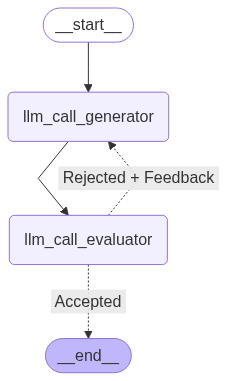

In [29]:
## Build workflow
optimizer_builder = StateGraph(State)

## Add the Nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

## Add Edges to connect Nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  ## Name returned by route_joke : Name of next node to visit
       ## Conditional Edge based on Feedback generated
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

## Compile the workflow
optimizer_workflow = optimizer_builder.compile()

## Display the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [30]:
# Invoke the Workflow
state = optimizer_workflow.invoke({"topic": "Dogs"})
print(state["joke"])

 Why did the scarecrow adopt a dog?

Because he needed a bark-ing buddy!


## AI Agents: Beyond Agent Workflows 

### Agent

- Workflows consisted of scafolding with predefined code paths and once we remove scofolding we get Agents
- Agents plan, take actions (via tool-calling) and respond to feedback (looped feedback)
- Benefits: 
    - Requirement when you need to solve open-ended problems and cannot layout as a workflow
    - Scaffolding is unnecessary and problem can be solved using an agent

- Structure: Human >> LLM Call >> [Action] >> Environment; Environment >> [Feedback] >> LLM Call 
- Action and Feedback in a loop between LLM Call and Environment and Stops post Required Output Generated

In [32]:
## Agent Example: Agent selects among different tools for invocation based on user input 

## Define different tools (multiply, add, divide)
from langchain_core.tools import tool

## Multiply two integers with a,b as arguments
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers with a,b as arguments"""

    return a * b

## Add two integers with a,b as arguments
@tool
def add(a: int, b: int) -> int:
    """Add two integers with a,b as arguments"""

    return a + b

## Divide two integers with a,b as arguments
@tool
def divide(a: int, b: int) -> float:
    """Divide two integers with a,b as arguments"""

    return a / b

In [33]:
## Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [34]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


## Define the Nodes
## LLM decides whether to call a tool or not
def llm_call(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }

## Performs the tool call
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


## Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
## Decide if we should continue the loop or stop based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

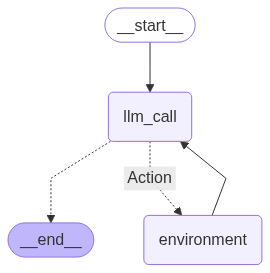

In [35]:
## Build the workflow
agent_builder = StateGraph(MessagesState)

# Add the Nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

## Add Edges to connect Nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

## Compile the agent
agent = agent_builder.compile()

## Display the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [36]:
## Invoke the agent
messages = [HumanMessage(content="Add 5 and 8. Then, take the output and multiply by 7")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 8. Then, take the output and multiply by 7
================================== Ai Message ==================================

 To solve this problem, we first need to find the sum of 5 and 8. So, let's add them: 5 + 8 = 13

Now that we have our result (13), let's multiply it by 7 as requested: 13 * 7 = 91

The final answer is 91.


### Pre-built method

- Above all methods were used to build workflows and agents from scratch
- Langchain does have a pre-built method that offers building workflows and agents without defining code

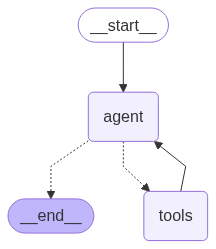

In [37]:
## Pre-built method: create_react_agent package

from langgraph.prebuilt import create_react_agent

## Arguments to Pass (Augmented LLM, Tools)
## (1) the augmented LLM with tools
## (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

## Display the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

In [38]:
## Invoke the agent
messages = [HumanMessage(content="Add 5 and 8.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 8.
================================== Ai Message ==================================
Tool Calls:
  add (d4e9809d-f87a-4101-a864-3ca97c7aac34)
 Call ID: d4e9809d-f87a-4101-a864-3ca97c7aac34
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

 The sum of 5 and 8 is 13.
